# Homology analysis using BLAST, Ete3 and Flags2


## Description

This notebook performs an exemplary homology analysis using (remote) BLAST, Ete3, and Flags2. It identifies homologous sequences, constructs phylogenetic trees, and visualizes the gene neighborhood (gene context) of the target gene in various target strains.

## Requirements

- `biopython` for sequence import and transformations
- `matplotlib` for plotting
- `ete3` for phylogenetic tree construction and visualization
- `flags2` (optional) for gene neighborhood visualization


To create a fresh conda environment and activate it:

```bash
conda create -p myenv -c conda-forge -c bioconda python=3.12 biopython matplotlib ete3
conda activate myenv
```

Or select the newly created environment as the kernel in Jupyter Notebook / Jupyter Lab.


## Input data

- for this example, all input data that is necessary is a protein sequence.
- we use the `input_pblast.fasta` file in `data/` containing a single sequence:

```
>ORF002752
MKVRPSVKPICEYCKVIRRNGRVMVICPTNPKHKQRQG*
```

## Remote (p)BLAST search (NCBI)

- the script `remote_blast.py` contains functions to perform remote BLAST searches against NCBI
- it uses Biopython's `Blast.qblast` function to submit the query and retrieve results
- the user can specify the BLAST program (e.g., `blastp`, `blastn`, etc.), the target database (e.g., `nr`, `refseq_protein`, etc.), and an optional taxonomic `filter` argument to limit the search to specific organisms/taxids
- the results are stored as an XML file, identical to the output that can be downloaded from the NCBI BLAST web page

In [1]:
%run -i ../source/remote_blast.py \
  -i ../data/input_pblast.fasta \
  -o ../output \
  -u example@gmail.com \
  -f "txid1301[ORGN]"

Started blastp for input: ../data/input_pblast.fasta
Input sequence has length: 39
Submitting BLASTP request to NCBI...
BLASTP result saved to: ../output/results.xml
Total hits found: 32
Top 3 BLASTP hits:

****Alignment****
protein: WP_000868345
description: MULTISPECIES: 50S ribosomal protein L36 [Bacteria]
length: 38
e value: 9.67109e-22
identity: 38
Query : Query_2048673 Length: 39 Strand: Plus
        unnamed protein product
Target: ref|WP_000868345.1| Length: 38 Strand: Plus
        MULTISPECIES: 50S ribosomal protein L36 [Bacteria]

Score:82 bits(262), Expect:1e-21,
Identities:38/38(100%),  Positives:38/38(100%),  Gaps:0.38(0%)

ref|WP_00         0 MKVRPSVKPICEYCKVIRRNGRVMVICPTNPKHKQRQG 38
                  0 |||||||||||||||||||||||||||||||||||||| 38
Query_204         0 MKVRPSVKPICEYCKVIRRNGRVMVICPTNPKHKQRQG 38


****Alignment****
protein: WP_136301433
description: 50S ribosomal protein L36 [Streptococcus pyogenes]
length: 38
e value: 2.34347e-21
identity: 37
Query : Query_20486

- in order to work with the BLAST result, we can parse it to FASTA sequences
- this is done using the script `parse_blast_result.py`
- it extracts all hits from the XML file and saves sequences as `.fasta` and protein IDs (`WP_` numbers) to `.txt` files

In [2]:
%run -i ../source/parse_blast_result.py \
  -i ../output/results.xml \
  -o ../output/results.fasta

Prepare FASTA file from input: ../output/results.xml
Total hits found: 32
Total hits after filtering: 23
Filtered BLASTP results saved to: ../output/results.fasta


- now that results are parsed to FASTA, we can align the sequences using `muscle`
- install it into the kernel env using `conda install -c bioconda muscle`
- the aligned sequences are saved to a new, aligned FASTA file


In [3]:
%%bash
muscle -align ../output/results.fasta \
  -output ../output/results_aligned.fasta


muscle 5.3.linux64 []  32.5Gb RAM, 22 cores
Built Jul 30 2025 21:13:04
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

[align ../output/results.fasta]
Input: 23 seqs, avg length 33, max 38, min 18

00:00 9.0Mb   100.0% Derep 23 uniques, 0 dupes
00:00 9.0Mb  CPU has 22 cores, running 22 threads
00:00 1.6Gb   100.0% Calc posteriors
00:00 1.6Gb   100.0% UPGMA5         
00:00 1.6Gb   100.0% Consistency (1/2)
00:00 1.6Gb   100.0% Consistency (2/2)Consistency (2/2)
00:00 1.6Gb   100.0% Refining         


In [4]:
!head -n 6 ../output/results_aligned.fasta

>WP_417159705 50S ribosomal protein L36, partial [Streptococcus pneumoniae] length=25 evalue=1.93602e-06 identity=20
MKVRPSVKPICEKCKVIRRRGKV---------------
>WP_214250541 50S ribosomal protein L36, partial [Streptococcus infantarius] length=29 evalue=1.49855e-13 identity=28
MKVRPSVKPICEYCKVIRRNGRVMVICPS---------
>WP_214250533 50S ribosomal protein L36, partial [Streptococcus infantarius] length=29 evalue=3.98306e-13 identity=27
MKVKPSVKPICEYCKVIRRNGRVMVICPS---------


## Cluster aligned sequences

- a recurring problem in homology searches is the presence of many highly similar sequences (e.g., from closely related strains/species)
- the following step uses a custom script `cluster_alignment.py` to cluster aligned sequences and prune redundant hits
- pruning works by selecting one representative sequence from each cluster based on a similarity threshold (e.g., 85%)
- the threshold means that e.g. all sequences with >85% identity are grouped in the same cluster


In [5]:
%run -i ../source/cluster_alignment.py \
  -i ../output/results_aligned.fasta \
  -o ../output/results_filtered_085.xml \
  --threshold 0.95

Reading alignment: ../output/results_aligned.fasta
Aligned sequences: 23
Cluster 1: 2 seqs -> representative WP_161512536
Cluster 2: 3 seqs -> representative WP_172060537
Cluster 3: 1 seqs -> representative WP_136301238
Cluster 4: 1 seqs -> representative WP_086163178
Cluster 5: 1 seqs -> representative WP_082306383
Cluster 6: 1 seqs -> representative WP_268768601
Cluster 7: 1 seqs -> representative WP_093651587
Cluster 8: 1 seqs -> representative WP_083899769
Cluster 9: 1 seqs -> representative WP_136301433
Cluster 10: 1 seqs -> representative WP_269761000
Cluster 11: 1 seqs -> representative WP_449160728
Cluster 12: 1 seqs -> representative WP_195187621
Cluster 13: 2 seqs -> representative WP_214250541
Cluster 14: 1 seqs -> representative WP_195187625
Cluster 15: 1 seqs -> representative WP_301833130
Cluster 16: 1 seqs -> representative WP_417159705
Cluster 17: 1 seqs -> representative WP_192804357
Cluster 18: 1 seqs -> representative WP_455168452
Cluster 19: 1 seqs -> representative

## Plot phylogenetic trees

- the previous step has exported a tree in `phyloxml` format based on the protein alignment
- we import `phyloxml` files and visualize trees using Ete3's `Tree` class
- all tree style options for Ete3 can be passed as a string using the `-s` argument
- each option is separated by a space, and key-value pairs are connected using `=` 

In [6]:
!export QT_QPA_PLATFORM=offscreen
%run -i ../source/phylogenetic_tree.py \
  -i ../output/results_filtered_085.xml \
  -o ../output/results_filtered_085_ete.svg \
  -t phylogram \
  -s "mode=c show_leaf_name=True arc_start=-90 arc_span=360 scale=600"

Legend written to: ../output/results_filtered_085_ete_legend.svg
Tree written to: ../output/results_filtered_085_ete.svg


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


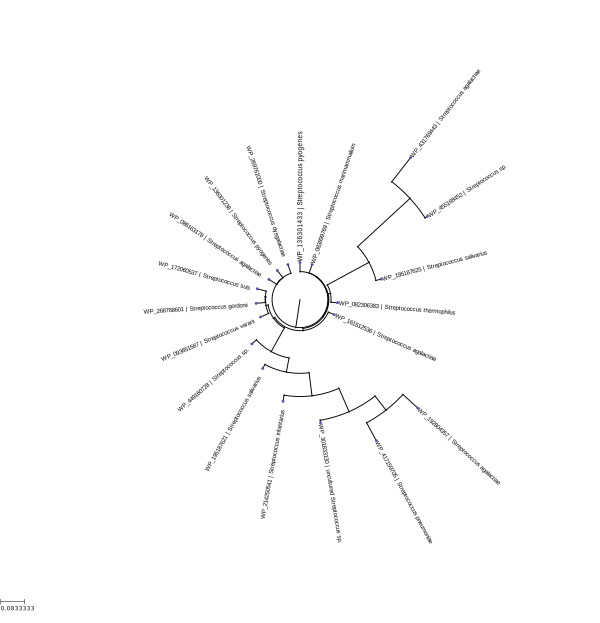

In [7]:
from IPython.display import SVG, display
display(SVG(filename='../output/results_filtered_085_ete.svg'))

## Analyse gene neighborhoods with Flags2

- also called gene context or synteny analysis
- Flags2 is a tool to visualize gene neighborhoods around a target gene in multiple genomes
- it can not be installed via conda, but requires manual installation from source (not covered here)

### Dependencies

- Flags2 requires the following dependencies which can be saved as a conda environment definition `flags2.yml`:

```yml
name: flags2
channels:
  - conda-forge
  - bioconda
  - etetoolkit
dependencies:
  - python=3.6.15
  - biopython=1.79
  - hmmer=3.4
  - mafft=6.861
  - ete3=3.1.2
  - ete_toolchain=3.0.0
  - fasttree=2.1.11
  - matplotlib=3.3.4
  - pandas=1.1.5
  - qt=5.12.9
  - pyqt=5.12.3
  - trimal=1.4.1
  - slr=1.4.3
```

- to create and activate the environment, run:

```bash
conda env create -f flags2.yml
conda activate flags2
```

### Flags2 usage

- TODO: example on how to run Flags2

## Session info

In [8]:
!pip freeze

anyio @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_anyio_1767719033/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1749017159514/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1762509342190/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_arrow_1760831179/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1763409923949/work
async-lru @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_async-lru_1768752884/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_attrs_1764875182/work
babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1738490167835/work
backports.zstd @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_backports.zstd_1767044984/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1764520477956/work
b